In [1]:
import sys
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter

from minot.ClusterTools import map_tools
import pitszi

# Cluster model

In [2]:
c = pitszi.Model(RA=42.0456*u.deg, Dec=10.0244*u.deg, redshift=0.4, M500=1e15*u.Msun, silent=True)

c.set_pressure_profile_universal_param('A10MD')

c.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                'Norm': 0.5, 
                                'slope': -11/3.0,
                                'Linj': 2*u.Mpc,
                                'Ldis': 1*u.kpc}

c.triaxiality = {'min_to_maj_axis_ratio':0.8, 'int_to_maj_axis_ratio':0.9,
                 'euler_angle1':40*u.deg, 'euler_angle2':50*u.deg, 'euler_angle3':45*u.deg}
        
c.map_coord  = SkyCoord(c.coord.ra+0.2*u.arcmin, c.coord.dec + 0*u.arcmin, frame="icrs")
c.map_fov   = [10, 10]*u.arcmin
c.map_reso  = 5*u.arcsec
c.los_reso  = 20*u.kpc
c.los_size  = 5*u.Mpc
c.R_truncation = c.R500*10

seed = None

print('')
print('----- Scale -----')
print('Pixel size in kpc: ', (c.D_ang*(c.map_reso).to_value('rad')).to('kpc'))
print('FoV in Mpc: ', (c.D_ang*(c.map_fov[0]).to_value('rad')).to('Mpc'))


----- Scale -----
Pixel size in kpc:  27.690031076734194 kpc
FoV in Mpc:  3.322803729208103 Mpc


Text(0.5, 1.0, 'Fluctuation pressure power spectrum')

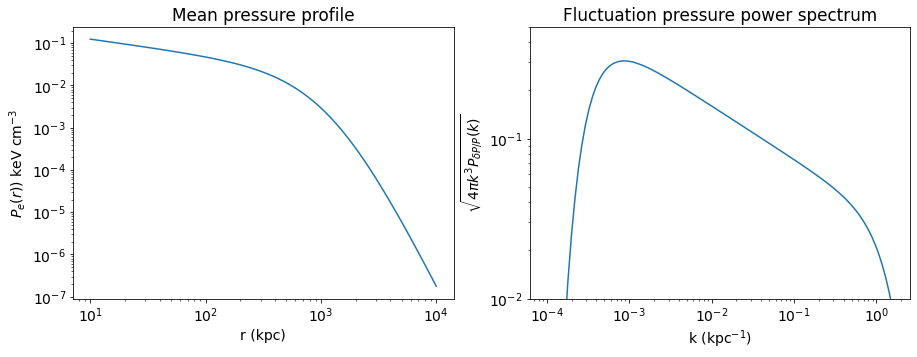

In [3]:
r, p_r = c.get_pressure_profile(radius=np.logspace(1,4,100)*u.kpc)

k, pk = c.get_pressure_fluctuation_spectrum(kvec=np.logspace(-1,3.2,100)*u.Mpc**-1)

plt.rcParams.update({'font.size': 14})
plt.figure(0, figsize=(15,5))
ax = plt.subplot(1, 2, 1)
plt.loglog(r, p_r)
plt.xlabel('r (kpc)')
plt.ylabel(r'$P_e(r))$ keV cm$^{-3}$')
plt.title('Mean pressure profile')

ax = plt.subplot(1, 2, 2)
plt.loglog(k.to_value('kpc-1'), np.sqrt(4*np.pi*k**3*pk).to_value(''))
plt.xlabel('k (kpc$^{-1}$)')
plt.ylabel(r'$\sqrt{4 \pi k^3 P_{\delta P / P}(k)}$')
plt.ylim(1e-2,5e-1)
plt.title('Fluctuation pressure power spectrum')

# Instrumental effects

In [4]:
#----- Filtering effects
beamFWHM = 18*u.arcsec

karcsec = np.linspace(0, 1/beamFWHM.to_value('arcsec')*10, 1000)
kfov = 1/(5*60)
TF = {'k':karcsec*u.arcsec**-1, 'TF':1-np.exp(-karcsec/kfov)}

Beam_k = pitszi.utils.gaussian_pk(karcsec, beamFWHM.to_value('arcsec'))

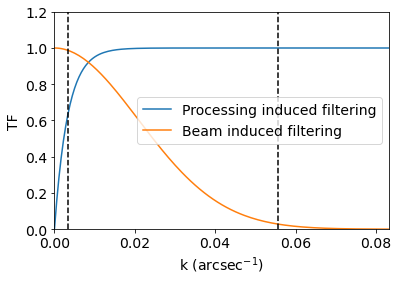

In [5]:
plt.rcParams.update({'font.size': 14})
plt.plot(TF['k_arcsec'], TF['TF'], label='Processing induced filtering')
plt.plot(karcsec, Beam_k, label='Beam induced filtering')
plt.axvline(kfov, color='k', ls='--')
plt.axvline(1/beamFWHM.to_value('arcsec'), color='k', ls='--')
plt.xlabel('k (arcsec$^{-1}$)')
plt.ylabel('TF')
plt.xlim(0, 1/beamFWHM.to_value('arcsec')*1.5)
plt.ylim(0,1.2)
plt.legend()

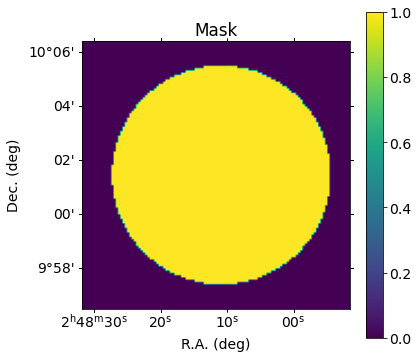

In [6]:
#----- Masking
mask_smoothing = beamFWHM*0

# Radial mask
ramap, decmap = map_tools.get_radec_map(c.get_map_header())
dist_map = map_tools.greatcircle(ramap, decmap, c.coord.ra.to_value('deg'), c.coord.dec.to_value('deg'))
mask = dist_map * 0 + 1
mask[dist_map > c.theta500.to_value('deg')] = 0 

# Point source-like mask
PSsize = 10 * u.arcsec
Nps = 0
for ips in range(Nps):
    loc_x = np.random.uniform(np.amin(ramap), np.amax(ramap))
    loc_y = np.random.uniform(np.amin(decmap), np.amax(decmap))
    dist_map = map_tools.greatcircle(ramap, decmap, loc_x, loc_y)
    mask[dist_map < PSsize.to_value('deg')] = 0 

# Smooth the mask
mask = gaussian_filter(mask, sigma=mask_smoothing.to_value('deg') / 2.35 / c.get_map_header()['CDELT2'])

# Show the mask
plt.figure(figsize=(6,6))
ax = plt.subplot(1, 1, 1, projection=WCS(c.get_map_header()))
plt.imshow(mask, vmin=0, vmax=1)
plt.colorbar()
plt.title('Mask')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

In [7]:
#----- What to apply
Apps_Beam = True
Apps_TF   = True
Apps_Mask = True

In [8]:
if not Apps_Beam: beamFWHM = 0*u.arcsec
if not Apps_TF: TF = {'k_arcsec':karcsec, 'TF':karcsec*0+1}
if not Apps_Mask: mask = mask*0+1

# Generate mock Pk 2d

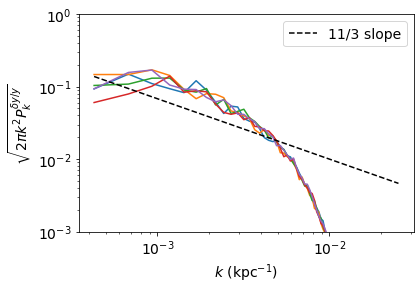

In [9]:
mask_sm = gaussian_filter(mask,3)
for imc in range(5):
    k_mock, pk_mock = c.get_mock_pk2d(seed=None, ConvbeamFWHM=beamFWHM, ConvTF=TF, 
                                      method_fluct='ratio', 
                                      mask=mask_sm, 
                                      method_pk='Naive',
                                      DeconvTF=TF,
                                      #DeconvBeamFWHM=beamFWHM
                                     )

    plt.loglog(k_mock.to_value('kpc-1'), np.sqrt(2*np.pi*k_mock**2*pk_mock).to_value(''))
plt.plot(k_mock.to_value('kpc-1'), 1e-2*((k_mock.to_value('kpc-1')/1e-2)**(-11/3+2))**0.5, 
         color='k', ls='--', label='11/3 slope')
plt.ylim(1e-3,1)
plt.ylabel(r'$\sqrt{2 \pi k^2 P_k^{\delta y / y}}$')
plt.xlabel(r'$k$ (kpc$^{-1}$)')
plt.legend()

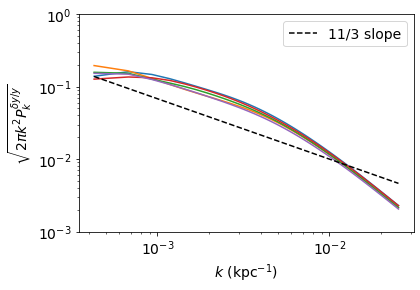

In [10]:
for imc in range(5):
    k_mock, pk_mock = c.get_mock_pk2d(seed=None, ConvbeamFWHM=beamFWHM, ConvTF=TF, 
                                      method_fluct='ratio', 
                                      mask=mask, 
                                      method_pk='Arevalo12',
                                      DeconvTF=TF,
                                      #DeconvBeamFWHM=beamFWHM
                                     )

    plt.loglog(k_mock.to_value('kpc-1'), np.sqrt(2*np.pi*k_mock**2*pk_mock).to_value(''))
plt.plot(k_mock.to_value('kpc-1'), 1e-2*((k_mock.to_value('kpc-1')/1e-2)**(-11/3+2))**0.5, 
         color='k', ls='--', label='11/3 slope')
plt.ylim(1e-3,1)
plt.ylabel(r'$\sqrt{2 \pi k^2 P_k^{\delta y / y}}$')
plt.xlabel(r'$k$ (kpc$^{-1}$)')
plt.legend()

# Data realization

In [11]:
# 3D cubes
fluct3d = c.get_pressure_cube_fluctuation(seed=seed)
prof3d  = c.get_pressure_cube_profile()

# Comptons maps
compton_true_fluct = c.get_sz_map(seed=seed)
compton_true_spher = c.get_sz_map(no_fluctuations=True)

Text(0.5, 0, '$k$ (kpc$^{-1}$)')

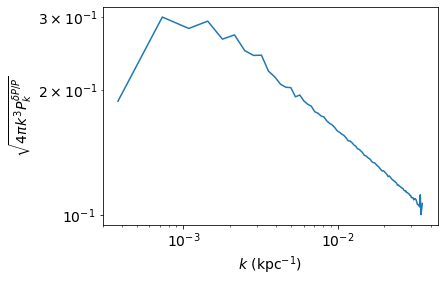

In [12]:
#----- Check the 3D Pk of data realization
Nx, Ny, Nz, proj_reso, proj_reso, los_reso = c.get_3dgrid()
k3d, pk3d = pitszi.utils.get_pk3d(fluct3d, proj_reso, los_reso)

plt.rcParams.update({'font.size': 14})
plt.loglog(k3d, (4*np.pi*k3d**3*pk3d)**0.5)
plt.ylabel(r'$\sqrt{4 \pi k^3 P_k^{\delta P / P}}$')
plt.xlabel(r'$k$ (kpc$^{-1}$)')

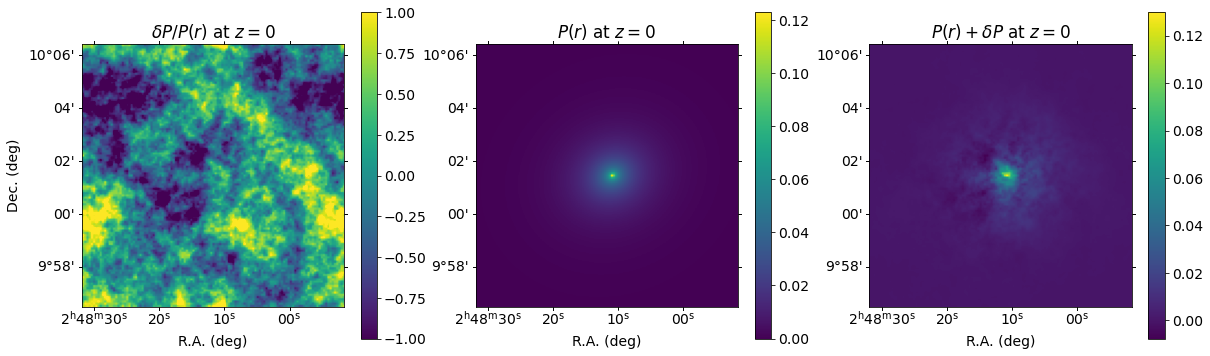

In [13]:
#----- Show the pressure fluctuation cube slice
plt.figure(figsize=(20,6))
ax = plt.subplot(1, 3, 1, projection=WCS(c.get_map_header()))
plt.imshow(fluct3d[:,:,int(fluct3d.shape[2]/2)].T, vmin=-1, vmax=1)
plt.colorbar()
plt.title(r'$\delta P / P(r)$ at $z=0$')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(1, 3, 2, projection=WCS(c.get_map_header()))
plt.imshow(prof3d[:,:,int(fluct3d.shape[2]/2)].T, vmin=0)
plt.colorbar()
plt.title(r'$P(r)$ at $z=0$')
plt.xlabel('R.A. (deg)')
plt.ylabel(' ')

ax = plt.subplot(1, 3, 3, projection=WCS(c.get_map_header()))
plt.imshow((prof3d*(1+fluct3d))[:,:,int(fluct3d.shape[2]/2)].T)
plt.colorbar()
plt.title('$P(r)+ \delta P$ at $z=0$')
plt.xlabel('R.A. (deg)')
plt.ylabel(' ')

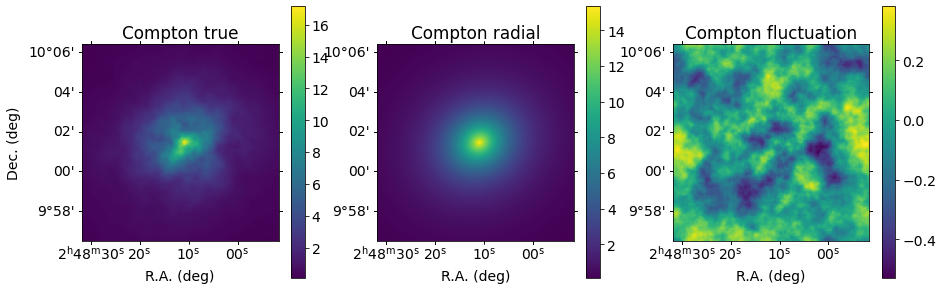

In [14]:
#----- Show the true Compton map
plt.figure(figsize=(15,5))
ax = plt.subplot(1, 3, 1, projection=WCS(c.get_map_header()))
plt.imshow(compton_true_fluct.T*1e5)
plt.colorbar()
plt.title('Compton true')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(1, 3, 2, projection=WCS(c.get_map_header()))
plt.imshow(compton_true_spher.T*1e5)
plt.colorbar()
plt.title('Compton radial')
plt.xlabel('R.A. (deg)')
plt.ylabel(' ')

ax = plt.subplot(1, 3, 3, projection=WCS(c.get_map_header()))
plt.imshow(((compton_true_fluct-compton_true_spher)/compton_true_spher).T)
plt.colorbar()
plt.title('Compton fluctuation')
plt.xlabel('R.A. (deg)')
plt.ylabel(' ')

# Apply instrumental effects

In [15]:
map_reso_arcsec = c.get_map_header()['CDELT2']*3600
map_reso_kpc    = (c.get_map_header()['CDELT2']*np.pi/180) * c.D_ang.to_value('kpc')
map_reso_arcsec, map_reso_kpc

(5.00000000000004, 27.69003107673441)

In [16]:
#----- Filtering effect
compton_dat_fluct = pitszi.utils.apply_transfer_function(compton_true_fluct, map_reso_arcsec, 
                                                         beamFWHM.to_value('arcsec'), TF, 
                                                         apps_TF_LS=Apps_TF, apps_beam=Apps_Beam)
compton_dat_spher = pitszi.utils.apply_transfer_function(compton_true_spher, map_reso_arcsec, 
                                                         beamFWHM.to_value('arcsec'), TF, 
                                                         apps_TF_LS=Apps_TF, apps_beam=Apps_Beam)
compton_datB_spher = pitszi.utils.apply_transfer_function(compton_true_spher, map_reso_arcsec, 
                                                         beamFWHM.to_value('arcsec'), TF, 
                                                         apps_TF_LS=False, apps_beam=Apps_Beam)

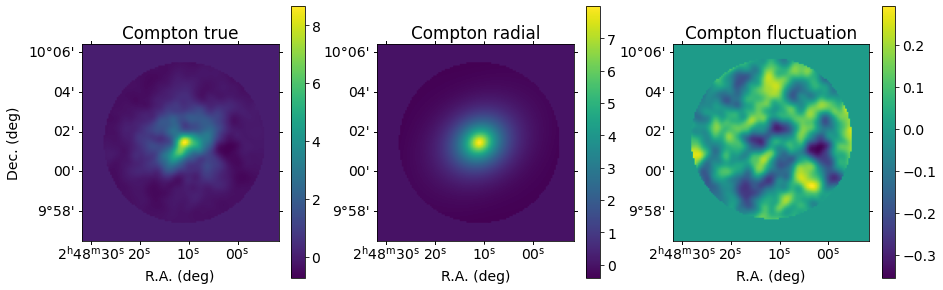

In [17]:
#----- Show the Compton map with instrumental effect
plt.figure(figsize=(15,5))
ax = plt.subplot(1, 3, 1, projection=WCS(c.get_map_header()))
plt.imshow(mask*compton_dat_fluct.T*1e5)
plt.colorbar()
plt.title('Compton true')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(1, 3, 2, projection=WCS(c.get_map_header()))
plt.imshow(mask*compton_dat_spher.T*1e5)
plt.colorbar()
plt.title('Compton radial')
plt.xlabel('R.A. (deg)')
plt.ylabel(' ')

ax = plt.subplot(1, 3, 3, projection=WCS(c.get_map_header()))
plt.imshow((mask*(compton_dat_fluct-compton_dat_spher)/compton_datB_spher).T)
plt.colorbar()
plt.title('Compton fluctuation')
plt.xlabel('R.A. (deg)')
plt.ylabel(' ')

# Extract Pk

In [18]:
# Which image to use
image = (compton_dat_fluct-compton_dat_spher)/compton_datB_spher 
image = image * mask

In [19]:
# Compute Pk
kbin_edges = np.linspace(0, 2e-2, 51)

k3d, pk3d  = c.extract_p3d(image, map_reso_kpc, kedges=kbin_edges, 
                           unbias=False, mask=mask, statistic='mean', method='Naive',
                           BeamDeconv=beamFWHM, TFDeconv=TF)

k3d_bis, pk3d_bis  = c.extract_p3d(image, map_reso_kpc, kedges=kbin_edges, 
                                   unbias=True, mask=mask, statistic='mean', method='Arevalo12',
                                   BeamDeconv=beamFWHM, TFDeconv=TF)

In [20]:
# Input Pk
ktrue, pktrue = c.get_pressure_fluctuation_spectrum(kvec=np.logspace(-4,0, 100)*u.kpc**-1)

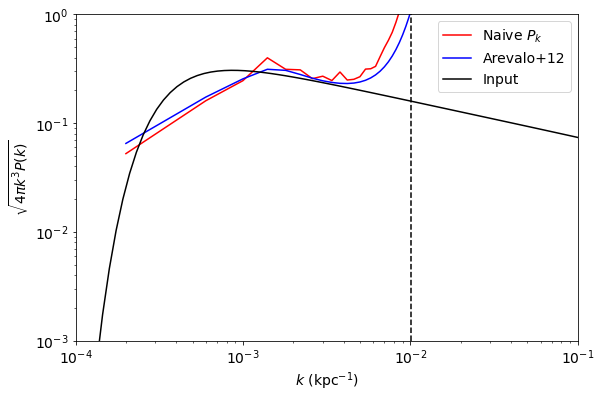

In [21]:
plt.figure(figsize=(9,6))
plt.loglog(k3d.to_value('kpc-1'), np.sqrt(4*np.pi*k3d**3*pk3d).to_value(''), color='r', label='Naive $P_k$')
plt.loglog(k3d_bis.to_value('kpc-1'), np.sqrt(4*np.pi*k3d_bis**3*pk3d_bis).to_value(''), color='b', label='Arevalo+12')
plt.loglog(ktrue.to_value('kpc-1'), np.sqrt(4*np.pi*ktrue**3*pktrue).to_value(''), color='k', label='Input')
plt.axvline(1/(beamFWHM.to_value('radian')*c.D_ang.to_value('kpc')), color='k', ls='--')
plt.xlabel(r'$k$ (kpc$^{-1}$)')
plt.ylabel(r'$\sqrt{4 \pi k^3 P(k)}$')
plt.ylim(1e-3, 1e0)
plt.xlim(1e-4, 1e-1)
plt.legend()

# Run MC realization

In [22]:
Nmc = 10
pk3d_mc = np.zeros((Nmc,len(kbin_edges)-1))
pk3d_bis_mc = np.zeros((Nmc,len(kbin_edges)-1))
c.silent = True
for imc in range(Nmc):
    compton_i = c.get_sz_map()
    compton_i = pitszi.utils.apply_transfer_function(compton_i, map_reso_arcsec, 
                                                     beamFWHM.to_value('arcsec'), TF, 
                                                     apps_TF_LS=Apps_TF, apps_beam=Apps_Beam)
    image_i = (compton_i-compton_dat_spher)/compton_datB_spher
    image_i = image_i * mask
    
    k3d_i, pk3d_i  = c.extract_p3d(image_i, map_reso_kpc, kedges=kbin_edges, 
                                   unbias=False, mask=mask, statistic='mean', method='Naive',
                                   BeamDeconv=beamFWHM, TFDeconv=TF)
    
    k3d_bis_i, pk3d_bis_i  = c.extract_p3d(image_i, map_reso_kpc, kedges=kbin_edges, 
                                   unbias=True, mask=mask, statistic='mean', method='Arevalo12',
                                   BeamDeconv=beamFWHM, TFDeconv=TF)
    
    pk3d_mc[imc, :] = pk3d_i
    pk3d_bis_mc[imc, :] = pk3d_bis_i

In [23]:
pk3d_mean = np.mean(pk3d_mc, axis=0)*u.kpc**3
pk3d_std  = np.std(pk3d_mc, axis=0)*u.kpc**3

pk3d_bis_mean = np.mean(pk3d_bis_mc, axis=0)*u.kpc**3
pk3d_bis_std  = np.std(pk3d_bis_mc, axis=0)*u.kpc**3

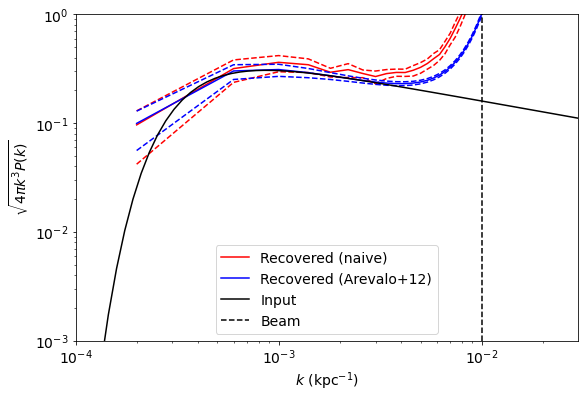

In [24]:
#----- Show the results
plt.figure(figsize=(9,6))
plt.loglog(k3d.to_value('kpc-1'), np.sqrt(4*np.pi*k3d**3*pk3d_mean).to_value(''), color='r', ls='-', label='Recovered (naive)')
plt.loglog(k3d.to_value('kpc-1'), np.sqrt(4*np.pi*k3d**3*(pk3d_mean+pk3d_std)).to_value(''), color='r', ls='--')
plt.loglog(k3d.to_value('kpc-1'), np.sqrt(4*np.pi*k3d**3*(pk3d_mean-pk3d_std)).to_value(''), color='r', ls='--')
plt.loglog(k3d.to_value('kpc-1'), np.sqrt(4*np.pi*k3d**3*pk3d_bis_mean).to_value(''), color='b', ls='-', label='Recovered (Arevalo+12)')
plt.loglog(k3d.to_value('kpc-1'), np.sqrt(4*np.pi*k3d**3*(pk3d_bis_mean+pk3d_bis_std)).to_value(''), color='b', ls='--')
plt.loglog(k3d.to_value('kpc-1'), np.sqrt(4*np.pi*k3d**3*(pk3d_bis_mean-pk3d_bis_std)).to_value(''), color='b', ls='--')
#for imc in range(Nmc):
#    plt.loglog(k3d.to_value('kpc-1'), np.sqrt(4*np.pi*k3d**3*(pk3d_mc[imc,:]*u.kpc**3)).to_value(''), color='r', alpha=0.1)
#    plt.loglog(k3d.to_value('kpc-1'), np.sqrt(4*np.pi*k3d**3*(pk3d_bis_mc[imc,:]*u.kpc**3)).to_value(''), color='b', alpha=0.1)
plt.loglog(ktrue.to_value('kpc-1'), np.sqrt(4*np.pi*ktrue**3*pktrue).to_value(''), color='k', label='Input')
plt.axvline(1/(beamFWHM.to_value('radian')*c.D_ang.to_value('kpc')), color='k', ls='--', label='Beam')
plt.xlabel(r'$k$ (kpc$^{-1}$)')
plt.ylabel(r'$\sqrt{4 \pi k^3 P(k)}$')
plt.ylim(1e-3,1e0)
plt.xlim(0.5*np.amin(k3d.to_value('kpc-1')), 1.5*np.amax(k3d.to_value('kpc-1')))
plt.legend()